In [2]:
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np

In [4]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

In [6]:
from sklearn import model_selection
from sklearn.metrics import confusion_matrix,auc,precision_recall_curve,roc_curve
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from stellargraph import IndexedArray

In [7]:
import itertools
import matplotlib.pyplot as plt

In [8]:
def read_para(path):
    df = pd.read_csv(path,sep='\t',header=None)
    dic = {}
    for i in range(df.shape[0]):
        hla = df[0].iloc[i]
        paratope = df[1].iloc[i]
        try:
            dic[hla] = paratope
        except KeyError:
            dic[hla] = []
            dic[hla].append(paratope)
    return dic

In [9]:
def dict_inventory(inventory):
    dicA, dicB, dicC = {}, {}, {}
    dic = {'A': dicA, 'B': dicB, 'C': dicC}

    for hla in inventory:
        type_ = hla[4]  # A,B,C
        first2 = hla[6:8]  # 01
        last2 = hla[8:]  # 01
        try:
            dic[type_][first2].append(last2)
        except KeyError:
            dic[type_][first2] = []
            dic[type_][first2].append(last2)

    return dic

In [10]:
def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    #print(hla)
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])

In [11]:
class Graph_Constructor():

    @staticmethod
    def combinator(pep,hla):
        source = ['p' + str(i+1) for i in range(len(pep))]
        target = ['h' + str(i+1) for i in range(len(hla))]
        return source,target

    @staticmethod
    def numerical(pep,hla,after_pca,embed=12):   # after_pca [21,12]
        pep = pep.replace('X','-').upper()
        hla = hla.replace('X','-').upper()
        feature_array_pep = np.empty([len(pep),embed])
        feature_array_hla = np.empty([len(hla),embed])
        amino = 'ARNDCQEGHILKMFPSTWYV-'
        for i in range(len(pep)):
            feature_array_pep[i,:] = after_pca[amino.index(pep[i]),:]
        for i in range(len(hla)):
            feature_array_hla[i,:] = after_pca[amino.index(hla[i]),:]
        feature_array = np.concatenate([feature_array_pep,feature_array_hla],axis=0)
        #print(feature_array_pep.shape,feature_array_hla.shape,feature_array.shape)
        return feature_array

    @staticmethod
    def unweight_edge(pep,hla,after_pca):
        source,target = Graph_Constructor.combinator(pep,hla)
        combine = list(itertools.product(source,target))
        weight = itertools.repeat(1,len(source)*len(target))
        edges = pd.DataFrame({'source':[item[0] for item in combine],'target':[item[1] for item in combine],'weight':weight})
        feature_array = Graph_Constructor.numerical(pep,hla,after_pca)
        try:nodes = IndexedArray(feature_array,index=source+target)
        except: print(pep,hla,feature_array.shape)
        graph = StellarGraph(nodes,edges,node_type_default='corner',edge_type_default='line')
        return graph


    @staticmethod
    def Update_Edges(pep,hla,edges):
      #print("edges",edges)

      #pep = "KEHVFFSEY"
      #hla = "MMMMYYTMMKKRKYREISNT-ENNTT--YIYDYTKWVVQDYLSRY-"

      edges_weights = pd.read_csv('Edge_Weights_V3.txt',sep='\t',header = None)
      amino = 'ARNDCQEGHILKMFPSTWYV-'  

      edges_weights[20] = 0
      new_row = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0 }
      edges_weights = edges_weights.append(new_row, ignore_index=True)

      edges['weight'] = edges['weight'].astype(float)


      for i in range(0, len(edges)):
        #print(i,edges.iloc[i]['source'], edges.iloc[i]['target'],edges.iloc[i]['weight'])

        if ((edges.iloc[i]['source'][0] == "p") and (edges.iloc[i]['target'][0] == "p")):
          
          #print(i, (pep[(int([edges.iloc[i]['source'][1:]][0])-1)]), (pep[(int(([edges.iloc[i]['target'][1:]][0]))-1)]))
          #print(amino.index(pep[(int([edges.iloc[i]['source'][1:]][0])-1)]), amino.index(pep[(int([edges.iloc[i]['target'][1:]][0])-1)]))
          #print("Weight to be assigned :",edges_weights[amino.index(pep[(int([edges.iloc[i]['target'][1:]][0])-1)])][amino.index(pep[(int([edges.iloc[i]['source'][1:]][0])-1)])])

          edges.at[i,'weight'] = edges_weights[amino.index(pep[(int([edges.iloc[i]['source'][1:]][0])-1)])][amino.index(pep[(int([edges.iloc[i]['target'][1:]][0])-1)])]
          
          #print("Updated edge weight : ",edges.at[i,'weight'])


        elif ((edges.iloc[i]['source'][0] == "p") and (edges.iloc[i]['target'][0] == "h")):
          edges.at[i,'weight'] = edges_weights[amino.index(pep[(int([edges.iloc[i]['source'][1:]][0])-1)])][amino.index(hla[(int([edges.iloc[i]['target'][1:]][0])-1)])]

        elif ((edges.iloc[i]['source'][0] == "h") and (edges.iloc[i]['target'][0] == "p")):
          edges.at[i,'weight'] = edges_weights[amino.index(hla[(int([edges.iloc[i]['source'][1:]][0])-1)])][amino.index(pep[(int([edges.iloc[i]['target'][1:]][0])-1)])]

        elif ((edges.iloc[i]['source'][0] == "h") and (edges.iloc[i]['target'][0] == "h")):
          edges.at[i,'weight'] = edges_weights[amino.index(hla[(int([edges.iloc[i]['source'][1:]][0])-1)])][amino.index(hla[(int([edges.iloc[i]['target'][1:]][0])-1)])]


      #print("Printing Again:")  
      #for j in range(0, len(edges)):
      #  print(edges.iloc[j]['source'], edges.iloc[j]['target'],edges.iloc[j]['weight'])

      return edges   


    #Dual Hyper transformation
    @staticmethod
    def DHT(source,target,edges,feature_array):

      new_nodeslist= edges.index.tolist()
      New_weights = edges["weight"].tolist()

      print("new_nodes", new_nodeslist)
      print("New_weights", New_weights)

      feature_weights = np.array(New_weights)
      feature_weights_new = np.zeros((feature_weights.shape[0], 2))

      for i in range(feature_weights_new.shape[0]):
        feature_weights_new[i:, 0] = New_weights[i]


      print("feature_weights_new",feature_weights_new)
      print('feature_array Type',np.shape(feature_weights_new))
      print('index Type',np.shape(new_nodeslist))
      New_nodes = IndexedArray(feature_weights_new, index=new_nodeslist)

      # Finding the pairs
      new_substuff = []
      for L in range(1):
        for subset in itertools.combinations(new_nodeslist, 2):
          if len(subset) == 2: 
            new_substuff.append(subset)

      # Converting the pairs to data frames
      Edges_df = pd.DataFrame(new_substuff)
      Edges_df.columns = ["Source", "Target"]
      Edges_df['Edge'] = ''


      print(Edges_df.tail(5))


      print(len(Edges_df))
      # Updating the edges by referingto edges dataframe
      for i in range(len(Edges_df)):  

        if((edges.iloc[Edges_df.iloc[i]['Source']]['source']) == (edges.iloc[Edges_df.iloc[i]['Target']]['source'])):
          Edges_df.at[i,'Edge'] = edges.iloc[Edges_df.iloc[i]['Source']]['source']

        elif ((edges.iloc[Edges_df.iloc[i]['Source']]['target']) == (edges.iloc[Edges_df.iloc[i]['Target']]['target'])):
          Edges_df.at[i,'Edge'] = edges.iloc[Edges_df.iloc[i]['Source']]['target']

        elif ((edges.iloc[Edges_df.iloc[i]['Source']]['source']) == (edges.iloc[Edges_df.iloc[i]['Target']]['target'])):
          Edges_df.at[i,'Edge'] = edges.iloc[Edges_df.iloc[i]['Source']]['source']
          
        elif ((edges.iloc[Edges_df.iloc[i]['Source']]['target']) == (edges.iloc[Edges_df.iloc[i]['Target']]['source'])):
          Edges_df.at[i,'Edge'] = edges.iloc[Edges_df.iloc[i]['Source']]['target']       




      print(Edges_df)
      print('New Nodes Type',type(New_nodes))
      print('Edges_df Type',type(Edges_df))

      # test code, pls remove
      Edges_df.rename(columns={'Source': 'source', 'Target': 'target', 'Edge': 'weight'}, inplace=True)
      Edges_df['weight'] = 1


      return New_nodes,Edges_df
      #return None



    @staticmethod
    def weight_anchor_edge(pep,hla,after_pca):
        source, target = Graph_Constructor.combinator(pep, hla)
        combine = list(itertools.product(source, target))
        weight = itertools.repeat(1, len(source) * len(target))
        edges = pd.DataFrame({'source': [item[0] for item in combine], 'target': [item[1] for item in combine], 'weight': weight})
        for i in range(edges.shape[0]):
            col1 = edges.iloc[i]['source']
            col2 = edges.iloc[i]['target']
            col3 = edges.iloc[i]['weight']
            if col1 == 'a2' or col1 == 'a9' or col1 ==  'a10':
                edges.iloc[i]['weight'] = 1.5
        feature_array = Graph_Constructor.numerical(pep, hla, after_pca)
        nodes = IndexedArray(feature_array, index=source + target)
        graph = StellarGraph(nodes, edges, node_type_default='corner', edge_type_default='line')
        return graph

    @staticmethod
    def intra_and_inter(pep,hla,after_pca):
        source, target = Graph_Constructor.combinator(pep, hla)
        combine = list(itertools.product(source, target))
        weight = itertools.repeat(2, len(source) * len(target))
        edges_inter = pd.DataFrame({'source': [item[0] for item in combine], 'target': [item[1] for item in combine], 'weight': weight})
        intra_pep = list(itertools.combinations(source,2))
        intra_hla = list(itertools.combinations(target,2))
        intra = intra_pep + intra_hla
        weight = itertools.repeat(1,len(intra))
        edges_intra = pd.DataFrame({'source':[item[0] for item in intra],'target':[item[1] for item in intra],'weight':weight})
        edges = pd.concat([edges_inter,edges_intra])
        edges = edges.set_index(pd.Index(np.arange(edges.shape[0])))

        # Updating Edge weights
        Graph_Constructor.Update_Edges(pep,hla,edges)

        feature_array = Graph_Constructor.numerical(pep, hla, after_pca)
        nodes = IndexedArray(feature_array, index=source + target)
        print('feature_array Type',np.shape(feature_array))
        print('index Type',np.shape(source+target))

        # Dual Hyper Transfer
        New_nodes,new_Edges = Graph_Constructor.DHT(source,target,edges,feature_array)
        #Graph_Constructor.DHT(source,target,edges,feature_array)



        print('Nodes Type',type(nodes))
        #print('feature_array',feature_array)
        #print('feature_array size',feature_array.shape)
        #print('index', source + target)
        #print('index len', len(source + target))
        print('Edges Type',type(edges))

        # Creating DHT graphs
        #graph = StellarGraph(nodes, edges, node_type_default='corner', edge_type_default='line')
        graph = StellarGraph(New_nodes, new_Edges, node_type_default='corner', edge_type_default='line')
        return graph

    @staticmethod
    def entrance(df,after_pca,hla_dic,dic_inventory):
        graphs = []
        graph_labels = []
        for i in range(df.shape[0]):
            print(i)
            pep = df['peptide'].iloc[i]
            try:
                hla = hla_dic[df['HLA'].iloc[i]]
            except KeyError:
                hla = hla_dic[rescue_unknown_hla(df['HLA'].iloc[i],dic_inventory)]
            label = df['immunogenicity'].iloc[i]
            #if label != 'Negative': label = 0
            #else: label = 1
            #graph = Graph_Constructor.unweight_edge(pep,hla,after_pca)
            #graph = Graph_Constructor.unweight_edge(pep,hla,after_pca)
            graph = Graph_Constructor.intra_and_inter(pep,hla,after_pca)
            graphs.append(graph)
            graph_labels.append(label)
        graph_labels = pd.Series(graph_labels)
        return graphs,graph_labels

In [12]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=2, callbacks=[es],)
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]
    return history, test_acc

In [13]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size)
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size)

    return train_gen, test_gen

In [14]:
def draw_ROC(y_true,y_pred):

    fpr,tpr,_ = roc_curve(y_true,y_pred,pos_label=1)
    area_mine = auc(fpr,tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % area_mine)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
def draw_PR(y_true,y_pred):
    precision,recall,_ = precision_recall_curve(y_true,y_pred,pos_label=1)
    area_PR = auc(recall,precision)
    baseline = np.sum(np.array(y_true) == 1) / len(y_true)

    plt.figure()
    lw = 2
    plt.plot(recall,precision, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % area_PR)
    plt.plot([0, 1], [baseline, baseline], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve example')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
def draw_history(history):
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    plt.show()

In [17]:
def hla_df_to_dic(hla):
    dic = {}
    for i in range(hla.shape[0]):
        col1 = hla['HLA'].iloc[i]  # HLA allele
        col2 = hla['pseudo'].iloc[i]  # pseudo sequence
        dic[col1] = col2
    return dic

In [18]:
def retain_910(ori):
    cond = []
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        if len(peptide) == 9 or len(peptide) == 10:
            cond.append(True)
        else:
            cond.append(False)
    data = ori.loc[cond]
    data = data.set_index(pd.Index(np.arange(data.shape[0])))
    return data

In [19]:
    #ori_train = pd.read_csv('remove0123_sample100.csv')
    #ori_train = pd.read_csv('remove0123_sample100_Test.csv')
    ori_train = pd.read_csv('remove0123_test.csv')
    hla = pd.read_csv('hla2paratopeTable_aligned.txt',sep='\t')
    after_pca = np.loadtxt('after_pca.txt')
    hla_dic = hla_df_to_dic(hla)
    inventory = list(hla_dic.keys())
    dic_inventory = dict_inventory(inventory)

    ori_train['immunogenicity'], ori_train['potential'] = ori_train['potential'], ori_train['immunogenicity']

In [20]:
graphs, graph_labels = Graph_Constructor.entrance(ori_train, after_pca, hla_dic, dic_inventory)
generator = PaddedGraphGenerator(graphs=graphs)

0
feature_array Type (55, 12)
index Type (55,)
new_nodes [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

In [21]:
generator

In [22]:
gc_model = GCNSupervisedGraphClassification(
            layer_sizes=[64, 64],
            activations=["relu", "relu"],
            generator=generator,
            dropout=0.2, )


In [23]:
x_inp, x_out = gc_model.in_out_tensors()
predictions = Dense(units=32, activation="relu")(x_out)
predictions = Dense(units=16, activation="relu")(predictions)
predictions = Dense(units=1, activation="sigmoid")(predictions)
model = Model(inputs=x_inp, outputs=predictions)

In [24]:
model

In [25]:
graphs

In [26]:
graph_labels

0    0.347444
dtype: float64

In [27]:
model.compile(optimizer=Adam(0.001), loss=mean_squared_error)

In [28]:
graph_labels

0    0.347444
dtype: float64

In [29]:
print(ori_train.shape)
print(ori_train.index)


(1, 6)
RangeIndex(start=0, stop=1, step=1)


In [ ]:
train_index, test_index = model_selection.train_test_split(ori_train.index, train_size=0.5)

In [ ]:
def get_generators1(train_index, test_index, graph_labels):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values)
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values)

    return train_gen, test_gen

In [30]:
graphs[0]

In [31]:
#!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import networkx as nx
import matplotlib.pyplot as plt

In [33]:
g0 = StellarGraph.to_networkx(graphs[0])
#g1 = StellarGraph.to_networkx(graphs[1])

In [34]:
!pip install 'scipy>=1.8'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


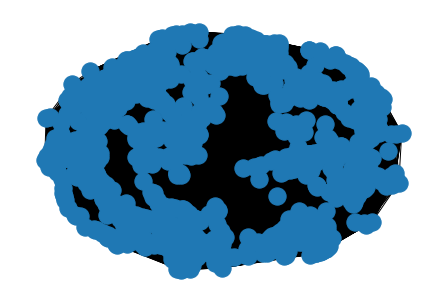

In [35]:
nx.draw(g0)

In [105]:
nx.draw(g1)

NameError: ignored

In [ ]:
import pandas as pd
from sklearn import model_selection

# Use scikit-learn to compute training and test sets
train_targets, test_targets = model_selection.train_test_split(graph_labels, train_size=0.5)

In [ ]:
import stellargraph as sg
import tensorflow as tf

# convert the raw data into StellarGraph's graph format for faster operations
#graph = sg.StellarGraph(nodes, edges)

generator = sg.mapper.FullBatchNodeGenerator(graphs[0], method="gcn")

# two layers of GCN, each with hidden dimension 16
gcn = sg.layer.GCN(layer_sizes=[16, 16], generator=generator)
x_inp, x_out = gcn.in_out_tensors() # create the input and output TensorFlow tensors

# use TensorFlow Keras to add a layer to compute the (one-hot) predictions
predictions = tf.keras.layers.Dense(units=len(train_targets), activation="softmax")(x_out)

# use the input and output tensors to create a TensorFlow Keras model
model = tf.keras.Model(inputs=x_inp, outputs=predictions)

Using GCN (local pooling) filters...


In [ ]:
len(train_targets)

75

In [ ]:
print(len(graph_labels))
print(len(graphs))

151
151


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(graphs, graph_labels, test_size = 0.33, random_state = 0)

#Steller Graphs

In [ ]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 56, Edges: 1540

 Node types:
  corner: [56]
    Features: float64 vector, length 12
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [1540]
        Weights: range=[0, 0.752989], mean=0.254575, std=0.269054
        Features: none


In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,151.0,151.0
mean,55.3,1500.3
std,0.4,24.7
min,55.0,1485.0
25%,55.0,1485.0
50%,55.0,1485.0
75%,56.0,1540.0
max,56.0,1540.0


In [ ]:
ori_train

,peptide,HLA,immunogenicity,test,respond,potential
0,ASTNRQSGRK,HLA-A*1101,0.076100,33,0,Negative
1,PIPSSWAFAK,HLA-A*1101,0.076080,33,0,Negative
2,HISCLTFGR,HLA-A*1101,0.076066,33,0,Negative
3,SCIQSQLRK,HLA-A*1101,0.075916,33,0,Negative
4,SLNFLGGAPK,HLA-A*1101,0.075677,33,0,Negative
...,...,...,...,...,...,...
146,AVYGNIKHK,HLA-A*1101,0.974766,1,1,Positive
147,LLWAARPRL,HLA-A*0201,0.974707,0,0,Positive
148,GAAFSGVSW,HLA-B*5801,0.974698,0,0,Positive
149,SVAGRVDGL,HLA-A*0205,0.974642,5,5,Positive


In [ ]:
ori_train1 = ori_train

In [ ]:
ori_train1

,peptide,HLA,immunogenicity,test,respond,potential
0,ASTNRQSGRK,HLA-A*1101,0.076100,33,0,Negative
1,PIPSSWAFAK,HLA-A*1101,0.076080,33,0,Negative
2,HISCLTFGR,HLA-A*1101,0.076066,33,0,Negative
3,SCIQSQLRK,HLA-A*1101,0.075916,33,0,Negative
4,SLNFLGGAPK,HLA-A*1101,0.075677,33,0,Negative
...,...,...,...,...,...,...
146,AVYGNIKHK,HLA-A*1101,0.974766,1,1,Positive
147,LLWAARPRL,HLA-A*0201,0.974707,0,0,Positive
148,GAAFSGVSW,HLA-B*5801,0.974698,0,0,Positive
149,SVAGRVDGL,HLA-A*0205,0.974642,5,5,Positive


In [ ]:
ori_train1.loc[ori_train1["potential"] != "Negative", "potential"] = 'Positive'

In [ ]:
ori_train1['potential'] = ori_train1['potential'].astype('category')
ori_train1['potential'] = pd.factorize(ori_train1['potential'])[0]

In [ ]:
ori_train1['potential']

0      0
1      0
2      0
3      0
4      0
      ..
146    1
147    1
148    1
149    1
150    1
Name: potential, Length: 151, dtype: int64

In [ ]:
graph_labels1 = ori_train1['potential']

In [ ]:
graph_labels.value_counts().to_frame()

,0
0.076100,1
0.976569,1
0.976488,1
0.976456,1
0.976428,1
...,...
0.981228,1
0.980895,1
0.979910,1
0.979685,1


In [ ]:
graph_labels1.value_counts().to_frame()

,potential
1,106
0,45


In [ ]:
graph_labels1 = pd.get_dummies(graph_labels1, drop_first=True)

In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)

In [ ]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])
    
    return model

In [ ]:
epochs = 200  # maximum number of training epochs
folds = 5  # the number of folds for k-fold cross validation
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

In [ ]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

In [ ]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=0, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [ ]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

In [ ]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels1, graph_labels1)

In [ ]:
graph_labels1

,1
0,0
1,0
2,0
3,0
4,0
...,...
146,1
147,1
148,1
149,1


In [ ]:
stratified_folds

<generator object _RepeatedSplits.split at 0x7f68d130a820>

In [ ]:
for i in enumerate(stratified_folds):
  print (i)

(0, (array([  0,   1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  13,  14,
        15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,  29,
        30,  31,  32,  34,  35,  36,  37,  40,  42,  44,  45,  46,  47,
        49,  50,  51,  52,  54,  55,  56,  59,  60,  62,  63,  64,  65,
        66,  68,  69,  71,  72,  73,  74,  76,  77,  78,  79,  80,  82,
        83,  84,  85,  86,  87,  89,  91,  92,  93,  95,  96,  97,  98,
        99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126,
       127, 128, 130, 133, 135, 136, 137, 138, 139, 141, 143, 144, 145,
       148, 149, 150]), array([  7,  12,  16,  26,  33,  38,  39,  41,  43,  48,  53,  57,  58,
        61,  67,  70,  75,  81,  88,  90,  94, 102, 121, 129, 131, 132,
       134, 140, 142, 146, 147])))
(1, (array([  0,   1,   2,   3,   5,   7,   8,   9,  10,  11,  12,  13,  16,
        17,  19,  20,  21,  23,  24,  26,  27,  28,  29,  30,  31, 

In [ ]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels1, graph_labels1)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels1, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 5...
Training and evaluating on fold 2 out of 5...
Training and evaluating on fold 3 out of 5...
Training and evaluating on fold 4 out of 5...
Training and evaluating on fold 5 out of 5...


In [ ]:
test_accs

[0.8387096524238586,
 0.8333333134651184,
 0.7333333492279053,
 0.8333333134651184,
 0.8999999761581421]

In [ ]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 82.8% and std: 5.4%


Text(0, 0.5, 'Count')

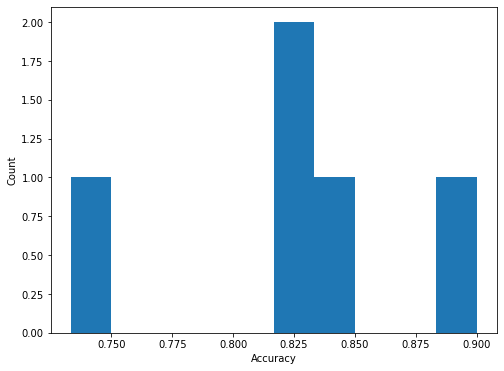

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

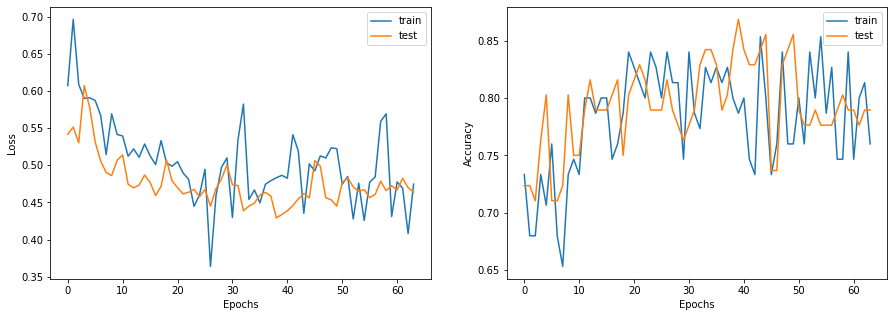

In [ ]:
display_learning_curves(history)

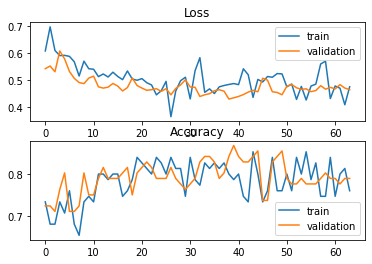

In [ ]:
draw_history(history)